### Data Source

##### https://archive.ics.uci.edu/dataset/365/polish+companies+bankruptcy+data

In [9]:
import pandas as pd
import numpy as np
from scipy.io import arff
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import os

In [3]:
df = pd.DataFrame()

for i in [x for x in os.listdir() if x.find('.arff')!=-1]:
    df = pd.concat([df,pd.DataFrame(arff.loadarff(i)[0])])
    
column_data = pd.read_excel('polish_company_data.xlsx')
column_data['COLUMN_NAME'] = column_data['COLUMN_NAME'].apply(lambda x:x.replace('X','Attr'))
column_data.loc[64,'COLUMN_NAME']='class'
column_data.loc[64,'FINANCIAL_RATIO']='BANKRUPCY_FLAG'

df = df.rename(columns={column_data['COLUMN_NAME'].tolist()[x]:column_data['FINANCIAL_RATIO'].tolist()[x] for x in range(len(column_data['COLUMN_NAME']))})

df['BANKRUPCY_FLAG'] = df['BANKRUPCY_FLAG'].apply(lambda x:int(x))


## Initial Data Review

In [ ]:
# Remove 8 Records with NA for Net Profit / Total Assets

df1 = df[df['net profit / total assets'].notnull()]

for i in df1.columns:
    temp_df = df1[i].copy()
    
    print(i)
    print(f'Null Records:{len(temp_df[temp_df.isnull()])}')
    print(f'Zero Records:{len(temp_df[temp_df==0])}')
    print(f'Max:{temp_df.max()}')
    print(f'Min:{temp_df.min()}')
    print(f'Mean:{temp_df.mean()}')
    print(f'Variance:{temp_df.std()}')
    print(f"\n")

### Identify Words in Colums to Determine potential Similarity

In [5]:
word_dictionary = {}

for i in column_data['FINANCIAL_RATIO']:
    word = i.split()
    for i in word:
        try:
            word_dictionary[i] +=1
        except:
            word_dictionary[i] =1

### Classify the Types of Ratios which are included to understand what might be important  and how we might make a sparse model

In [7]:
column_type_df = pd.DataFrame(df.columns,columns=['Column Name'])

condition = [column_type_df['Column Name'].str.contains('profit|EBIT|expenses|cost of'),
             column_type_df['Column Name'].str.contains('current assets|equity|retained|capital'),
             column_type_df['Column Name'].str.contains('sales|receivables|inventory'),
             column_type_df['Column Name'].str.contains('working capital|total assets')]

values = ['Profitability Ratio',
          'Capitalization Ratio',
          'Turnover Ratio',
          'Liqudity Ratio']

column_type_df['Ratio Classification'] = np.select(condition,values,'Other')

column_type_df

,Column Name,Ratio Classification
0,net profit / total assets,Profitability Ratio
1,total liabilities / total assets,Liqudity Ratio
2,working capital / total assets,Capitalization Ratio
3,current assets / short-term liabilities,Capitalization Ratio
4,[(cash + short-term securities + receivables -...,Profitability Ratio
...,...,...
60,sales / receivables,Turnover Ratio
61,(short-term liabilities *365) / sales,Turnover Ratio
62,sales / short-term liabilities,Turnover Ratio
63,sales / fixed assets,Turnover Ratio


### Visual Review of Data

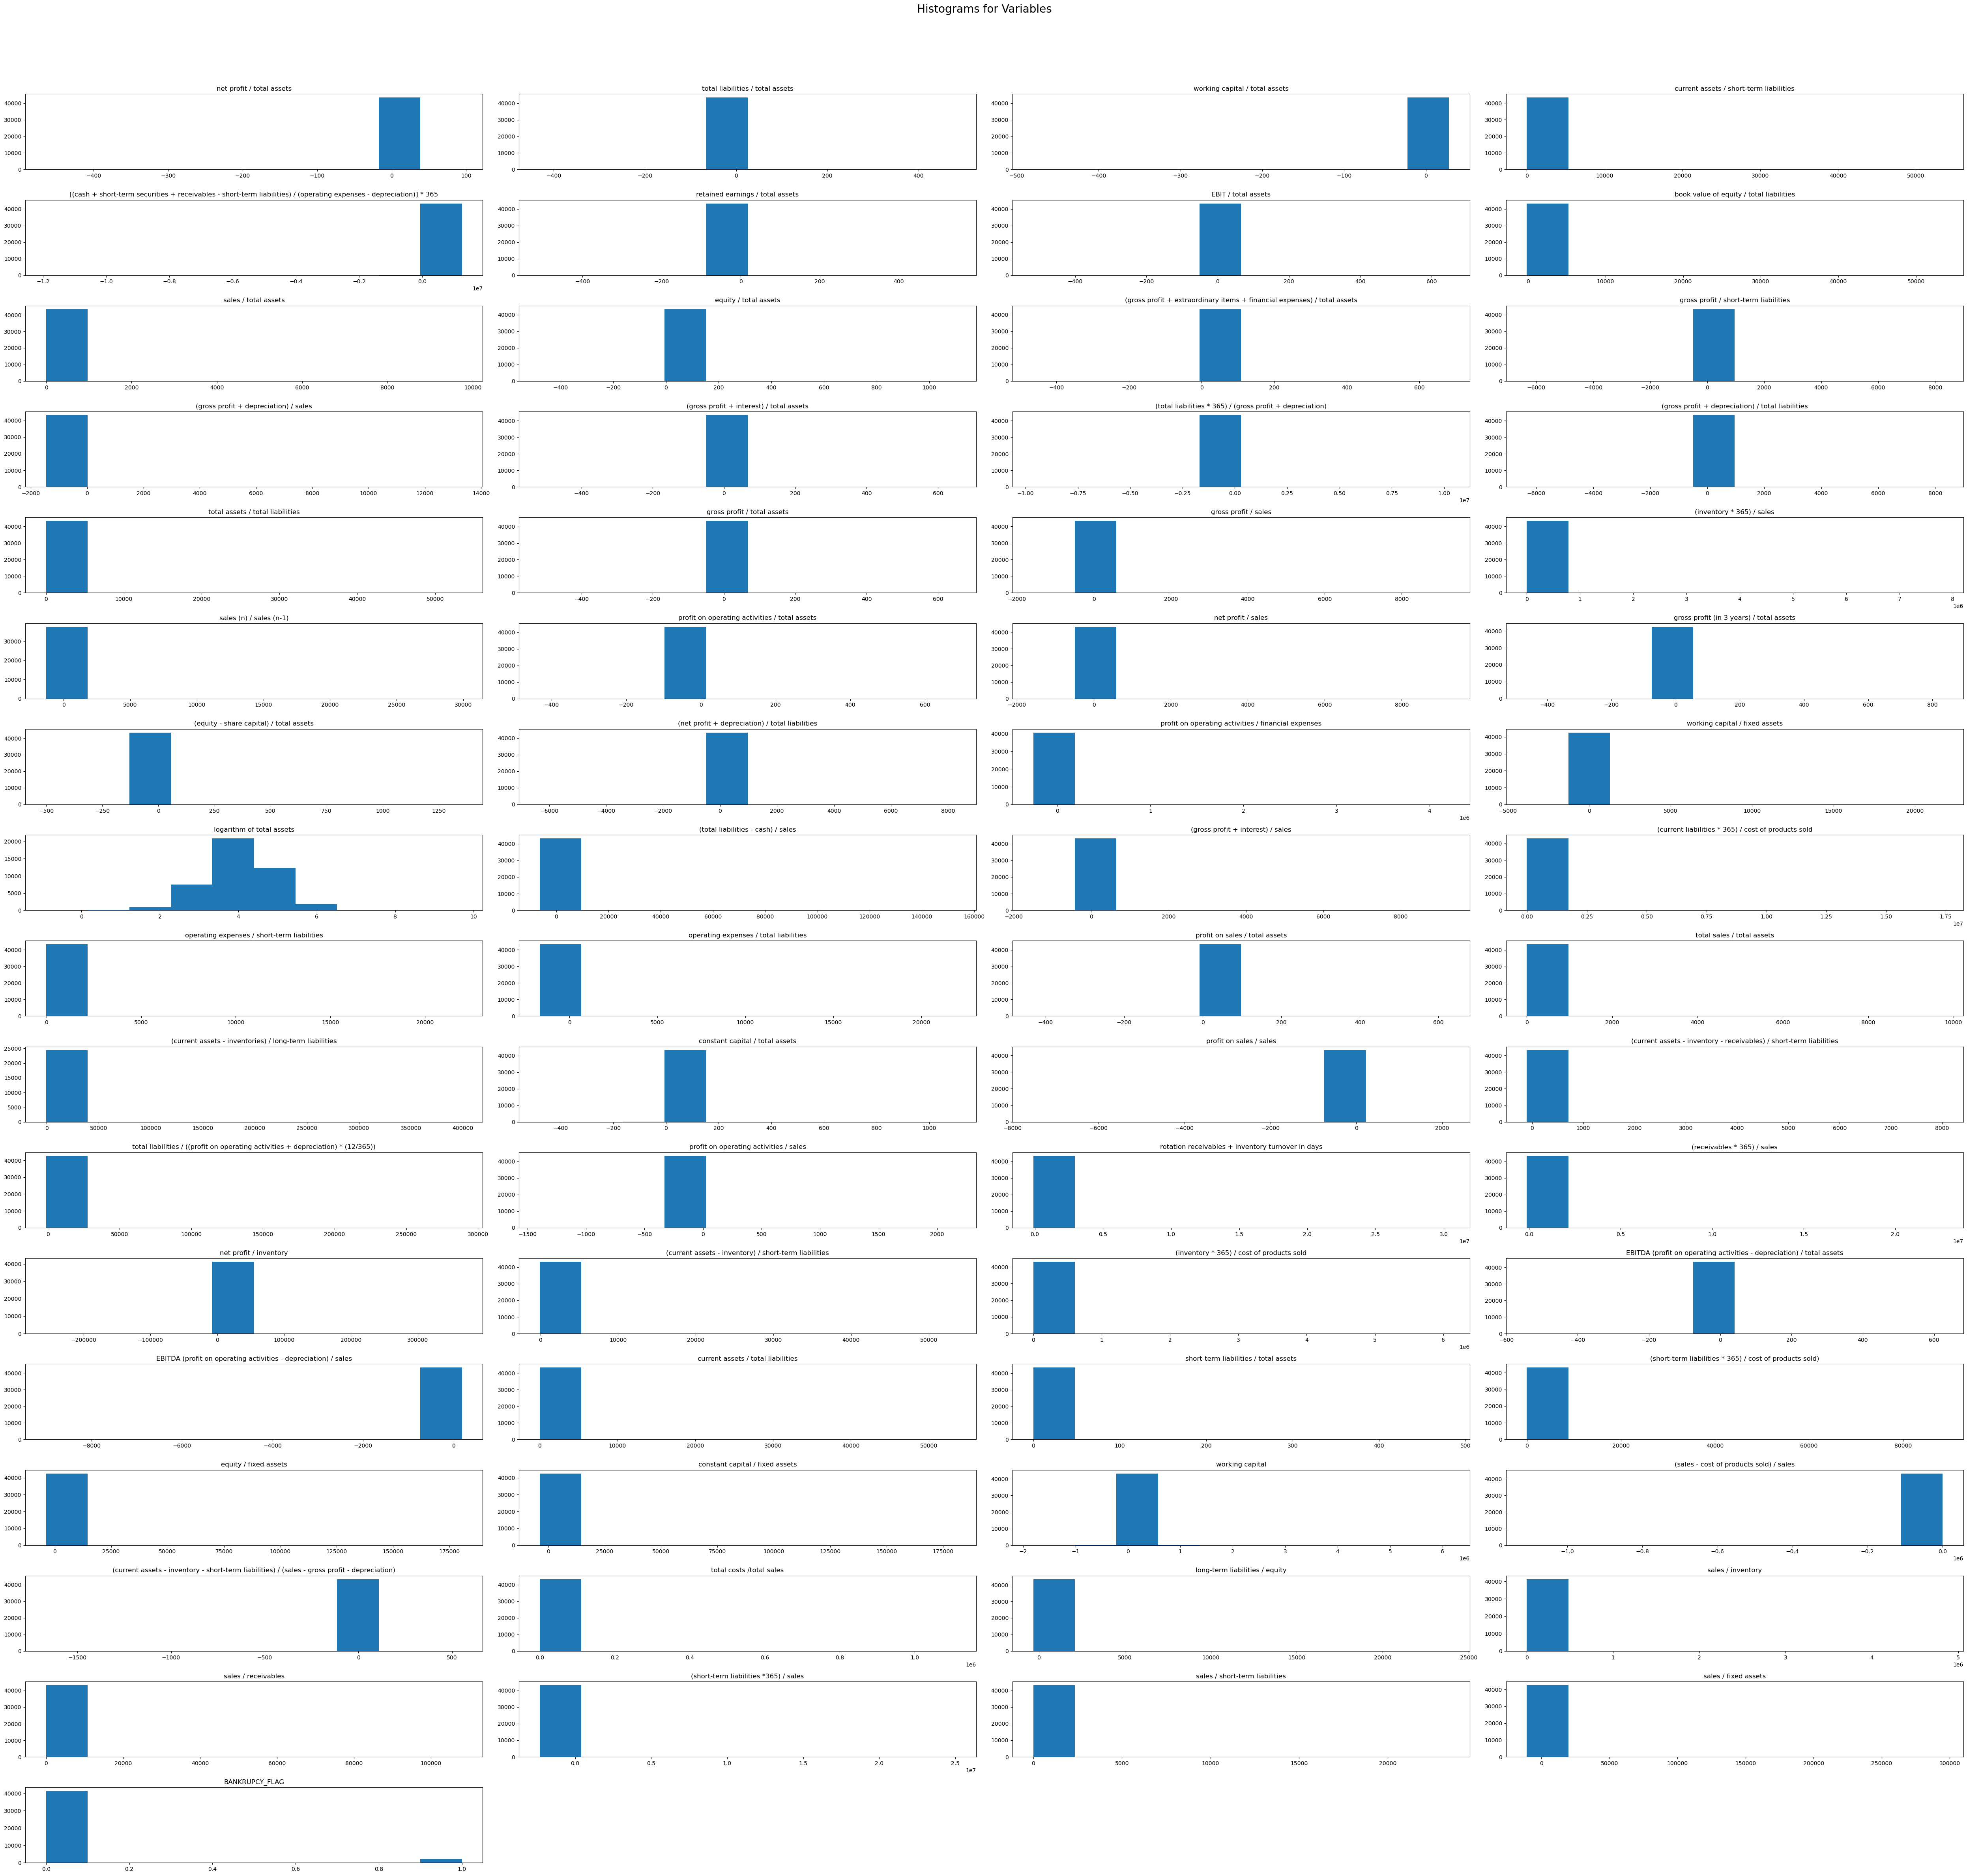

In [96]:
import math

fig = plt.figure(figsize=(50,50))

plt.suptitle('Histograms for Variables',fontsize='20')

l = math.ceil(len(df2.columns)/4)

for i in range(len(df2.columns)):
    plt.subplot(l,4,i+1)
    f = plt.gca()
    f.set_title(df2.columns[i])
    
    plt.hist(df2.iloc[:,i])
    
plt.tight_layout(rect=[0,0.03,1,.95])
plt.savefig("eda.pdf")

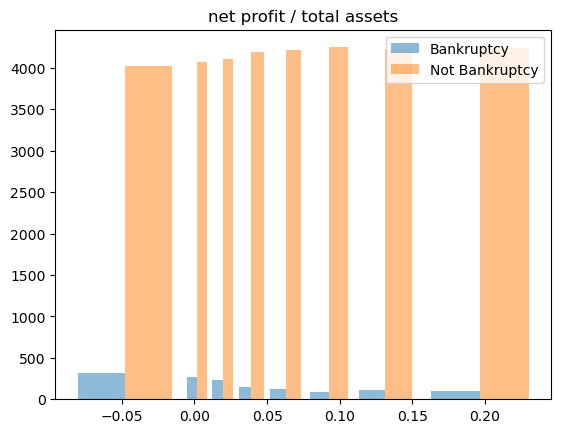

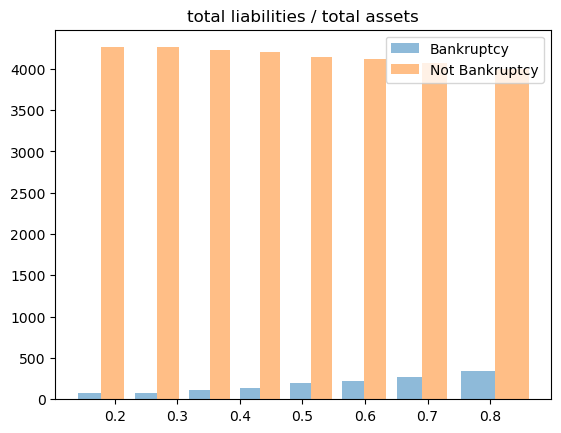

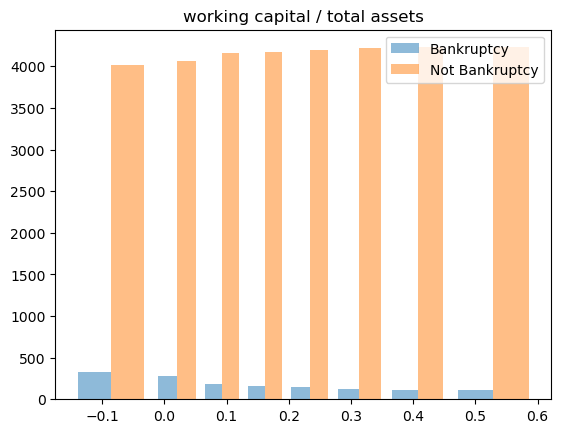

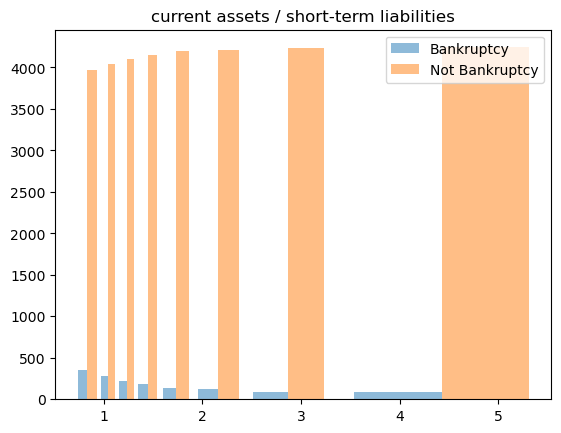

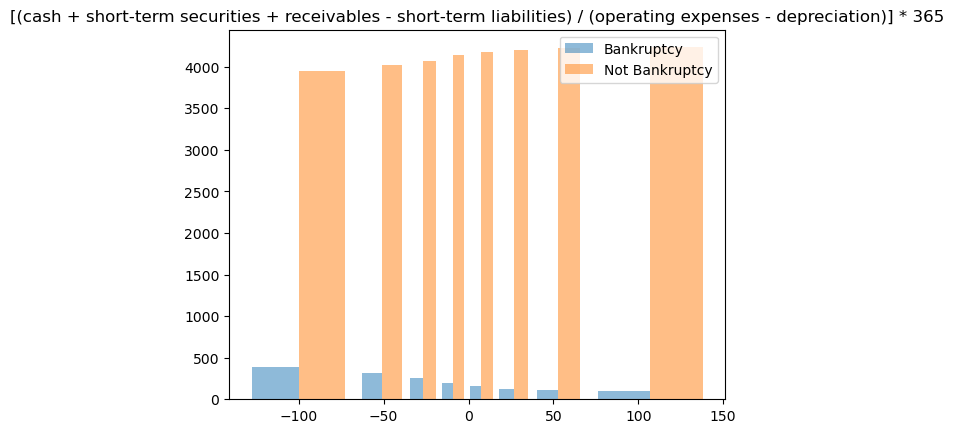

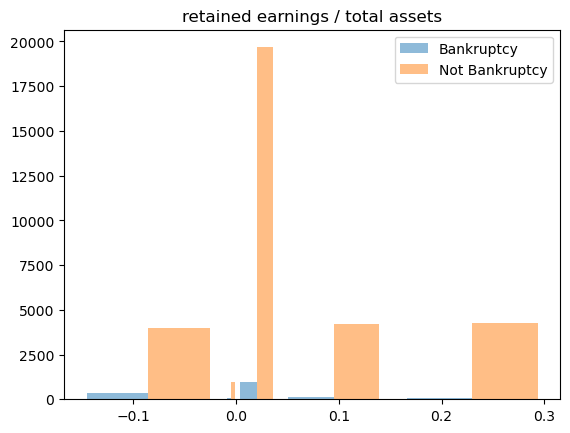

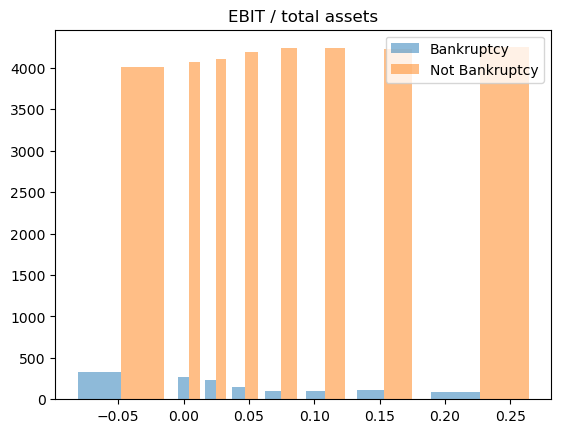

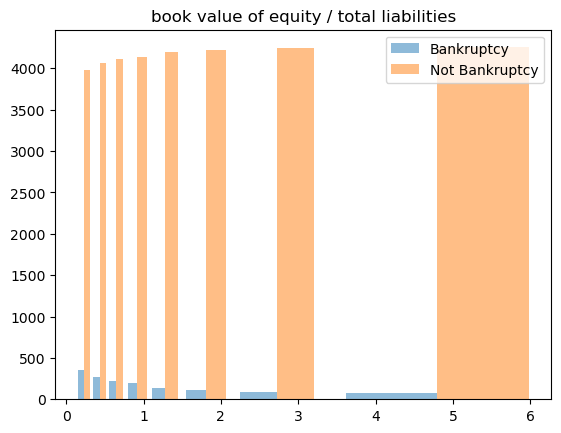

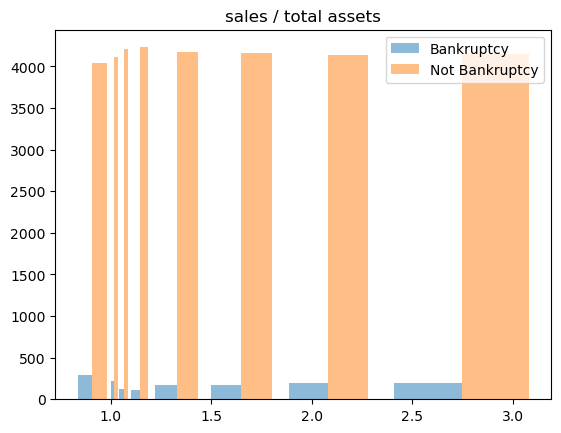

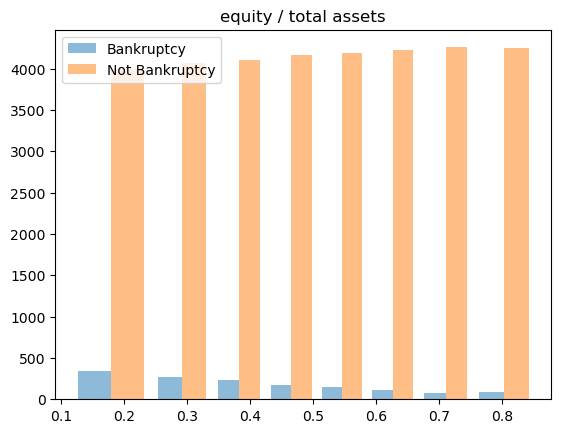

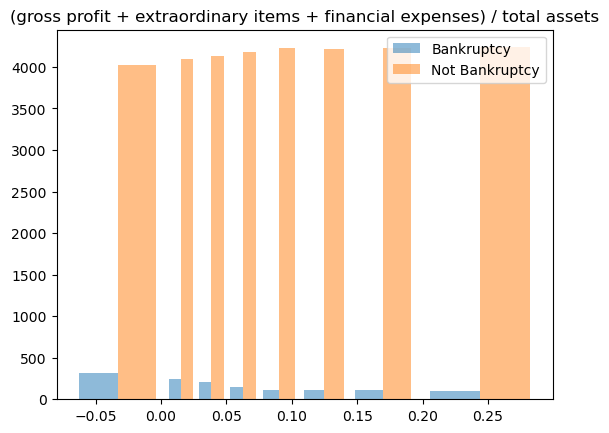

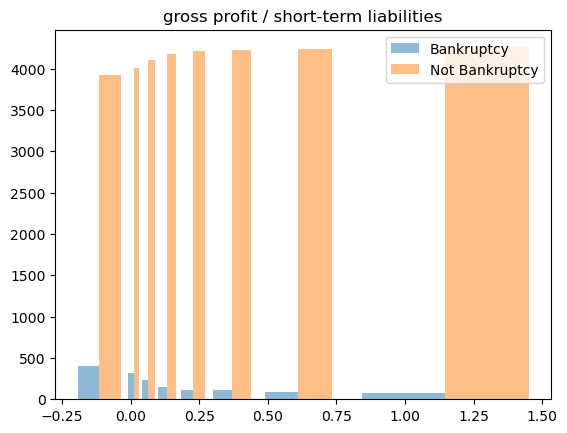

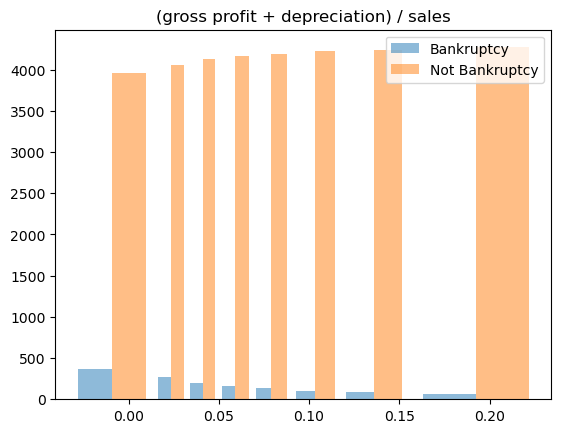

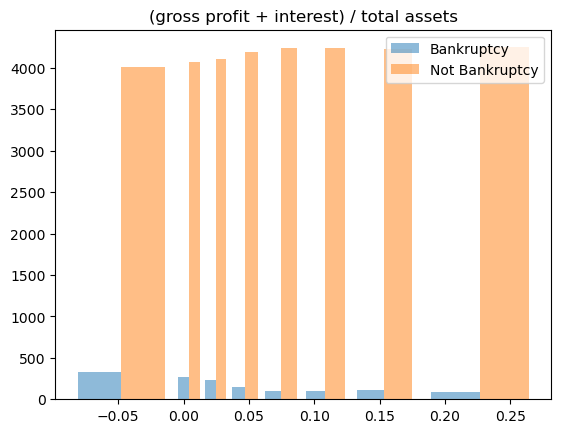

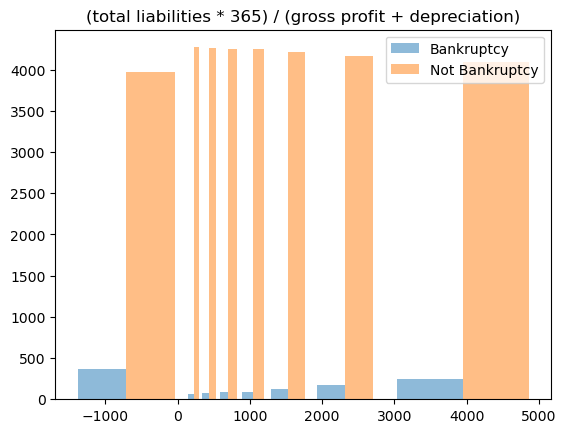

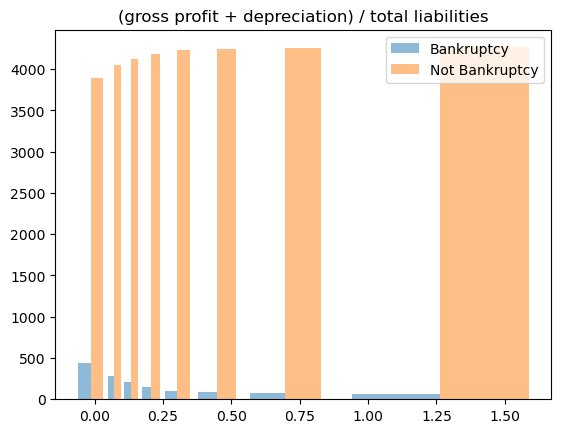

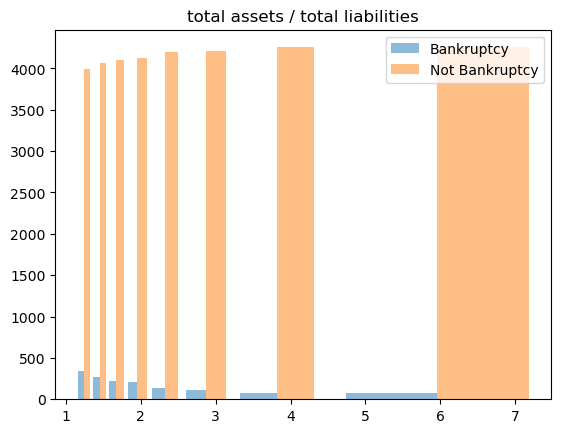

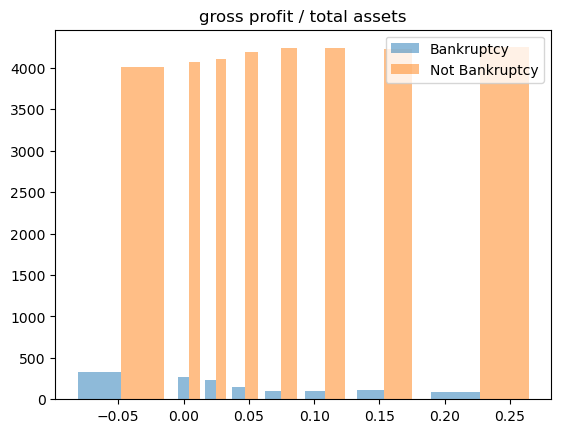

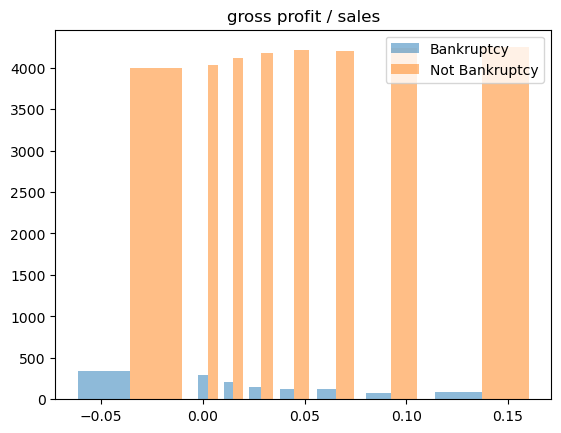

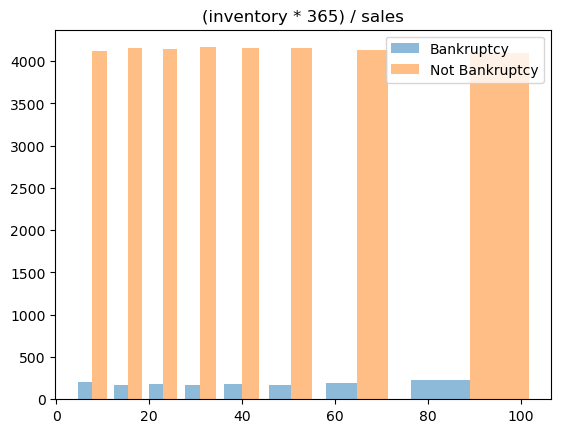

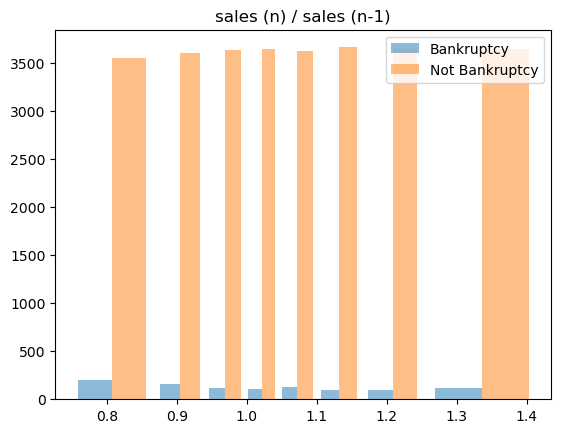

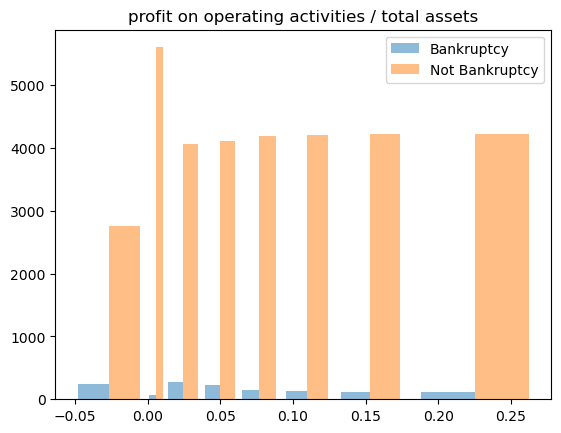

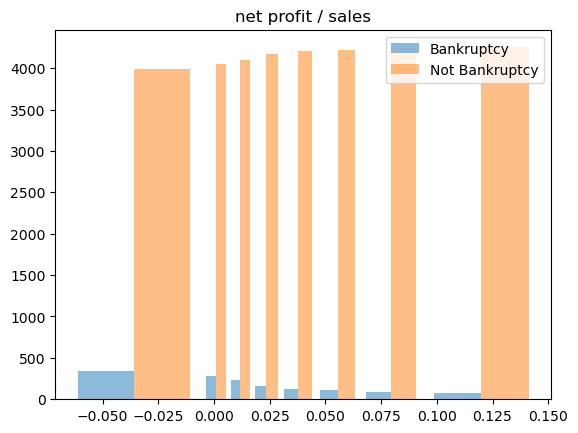

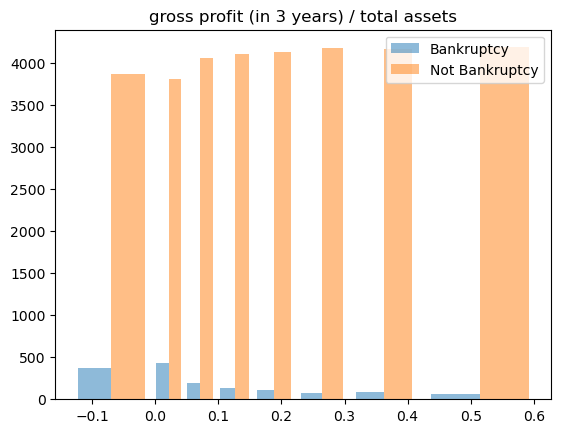

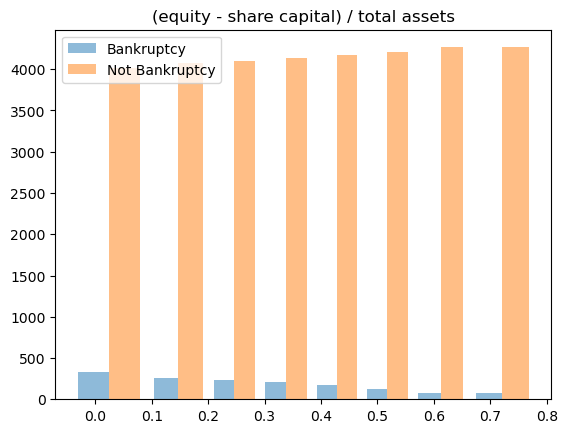

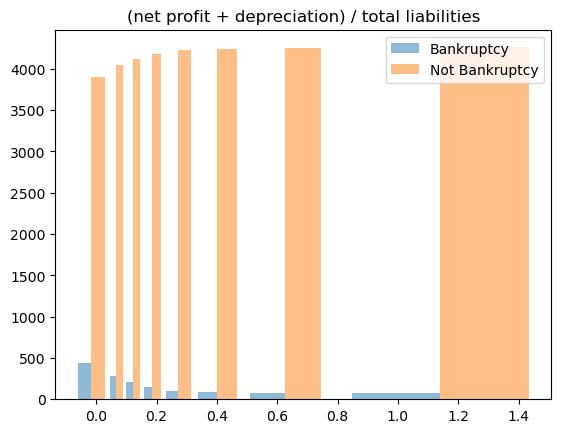

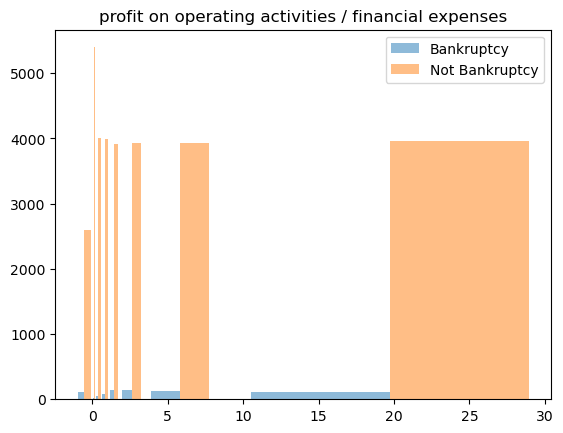

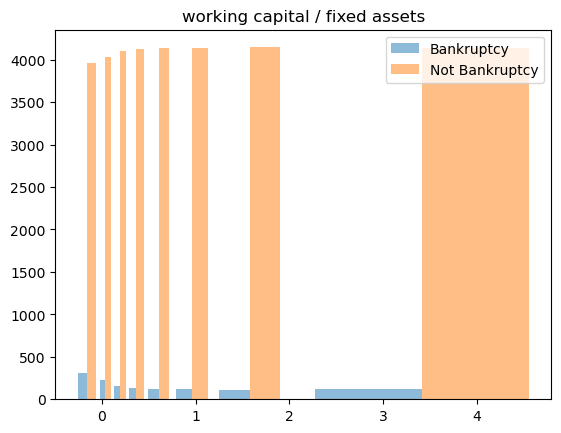

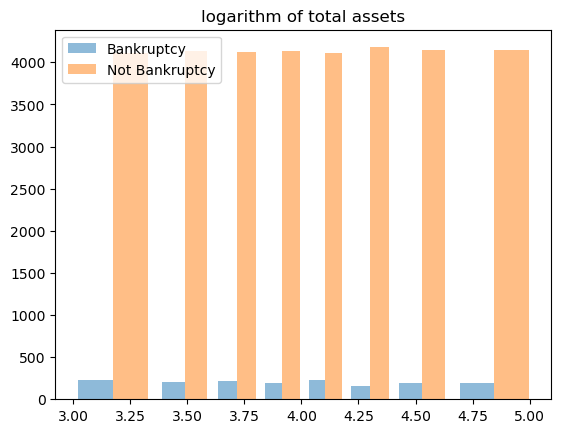

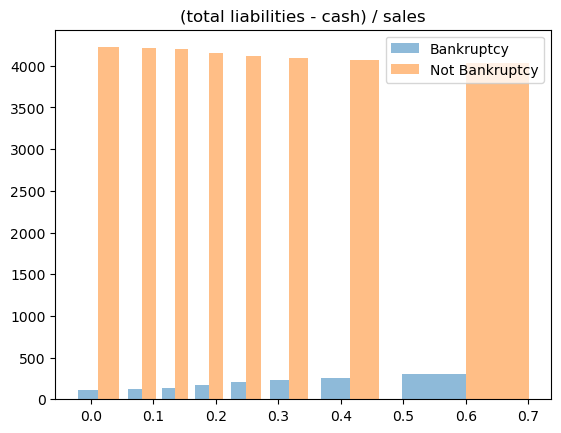

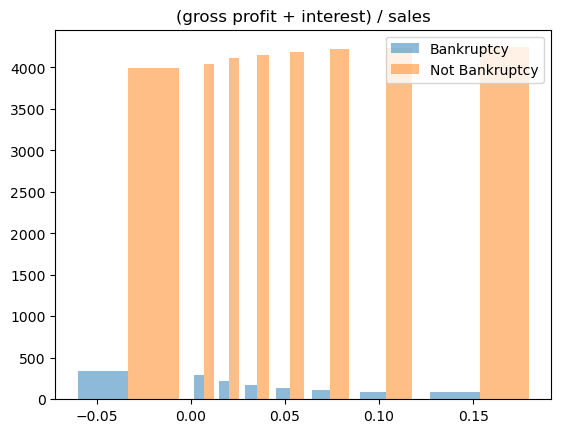

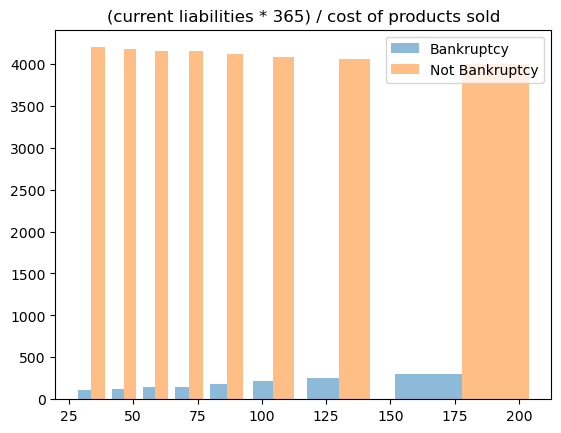

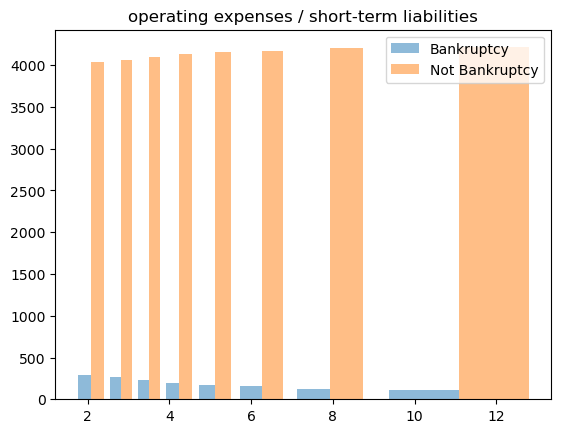

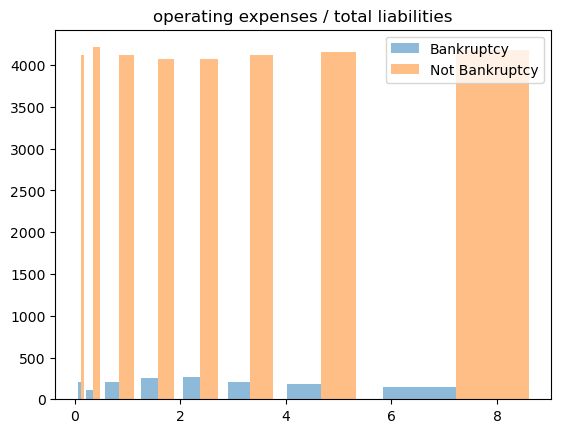

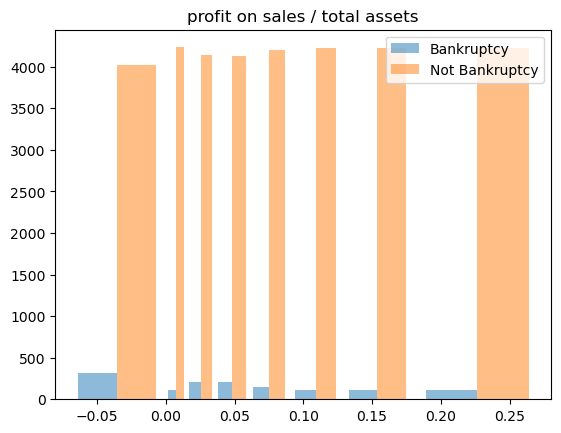

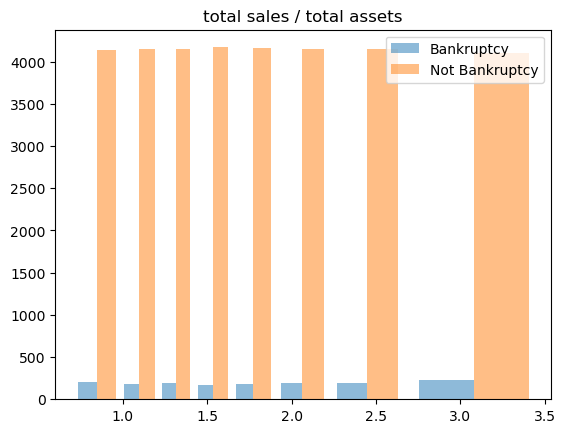

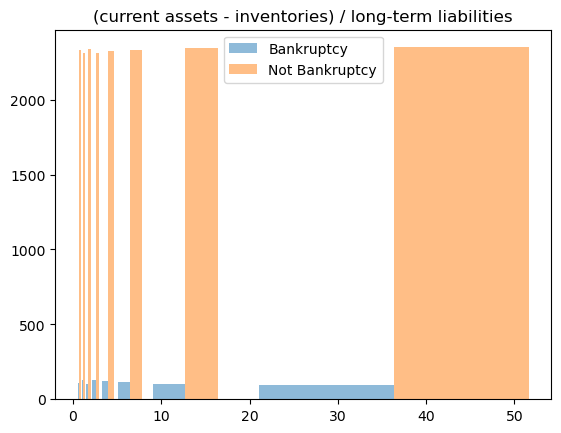

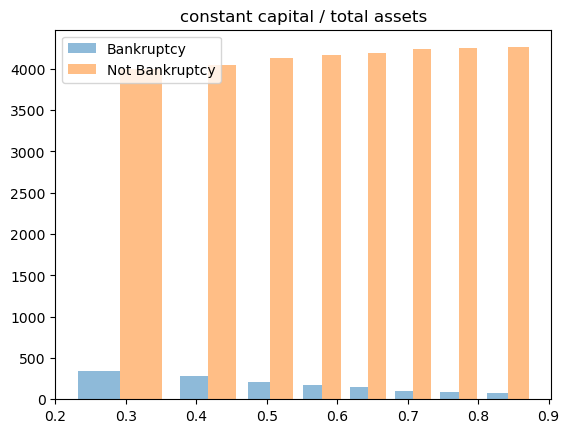

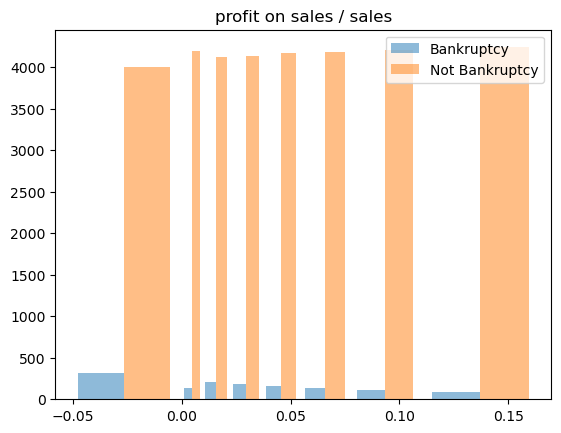

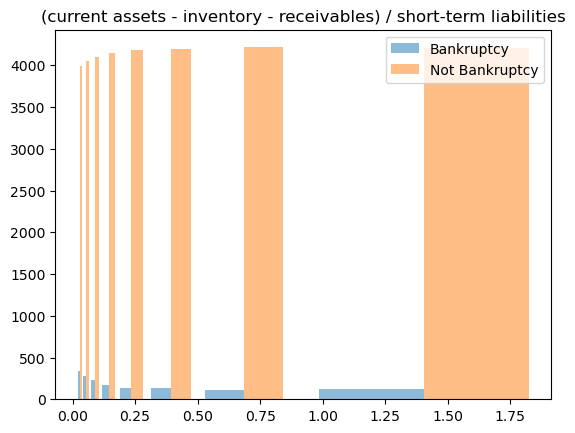

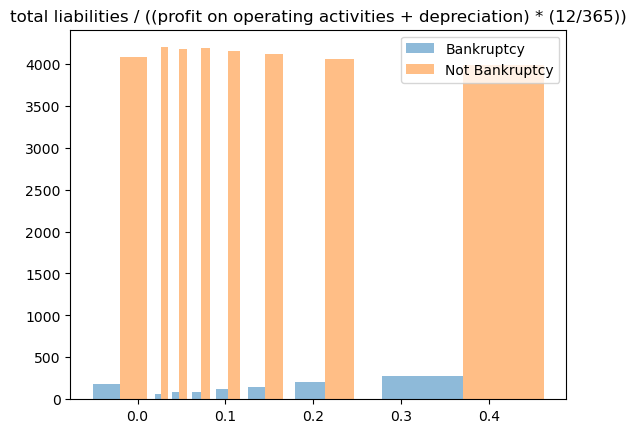

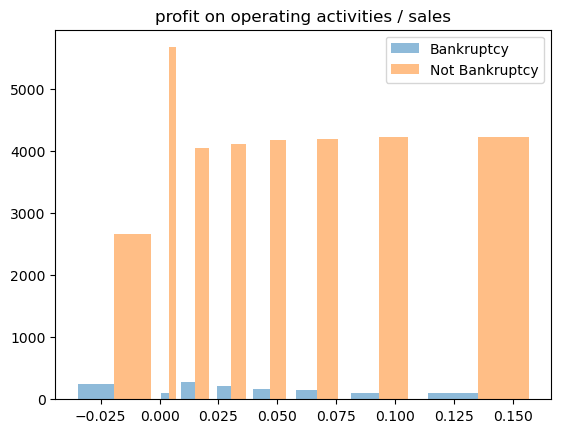

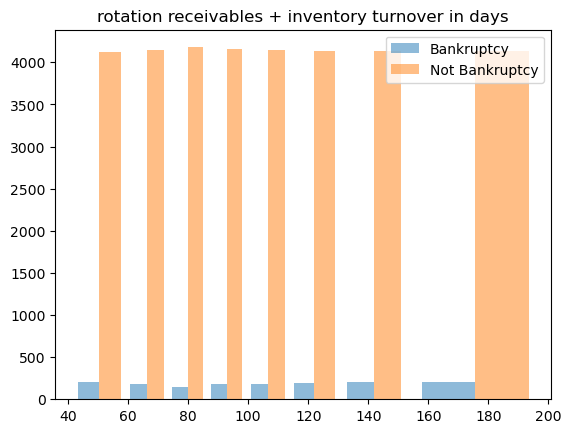

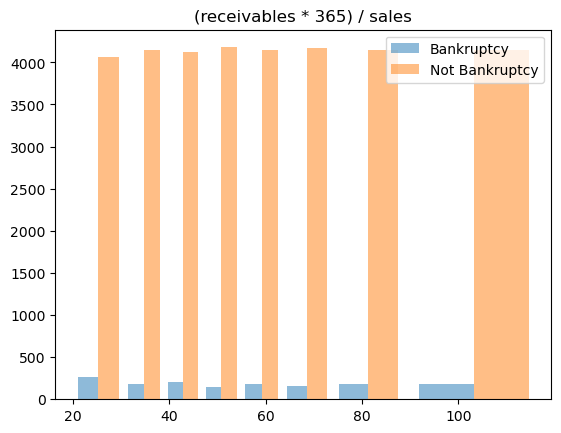

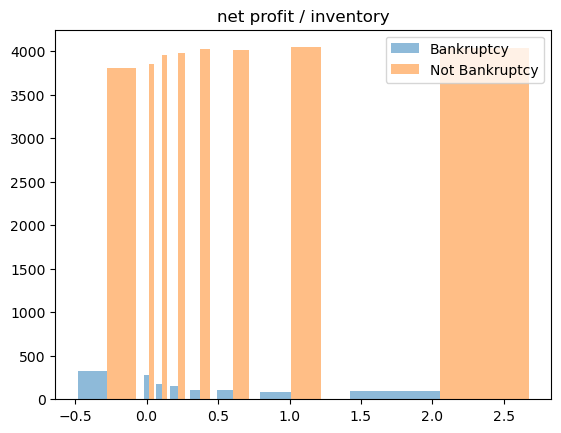

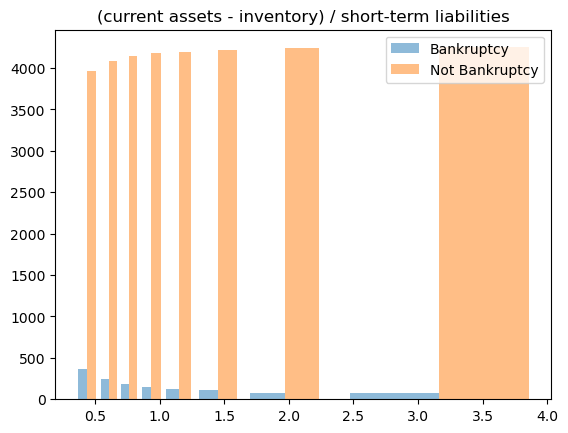

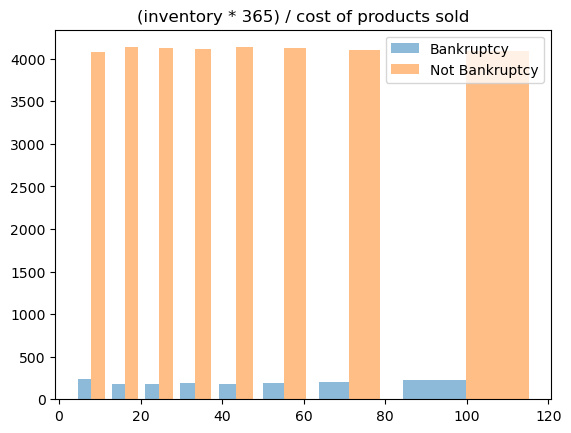

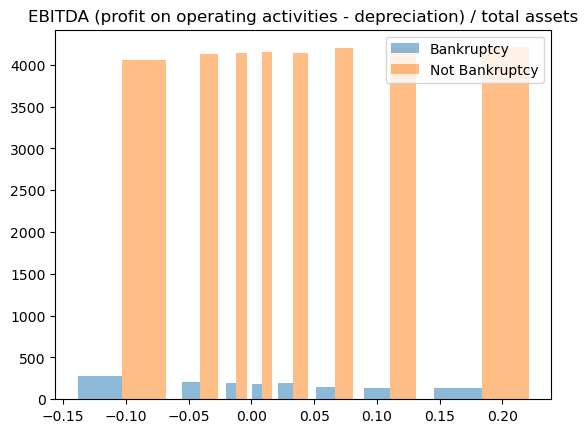

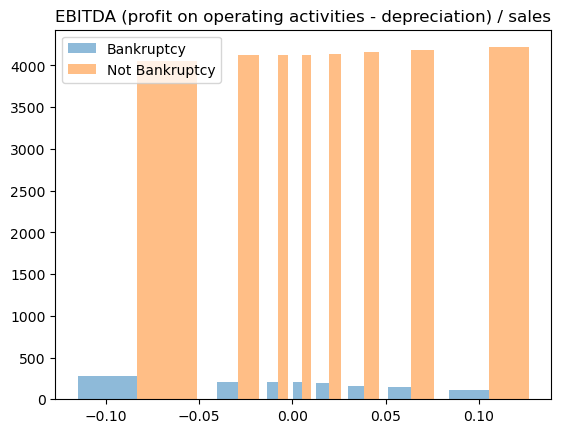

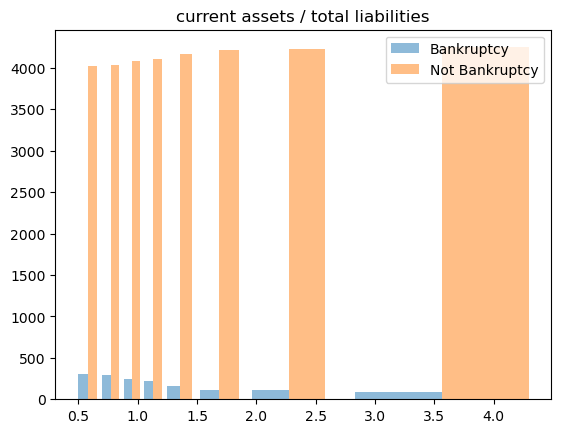

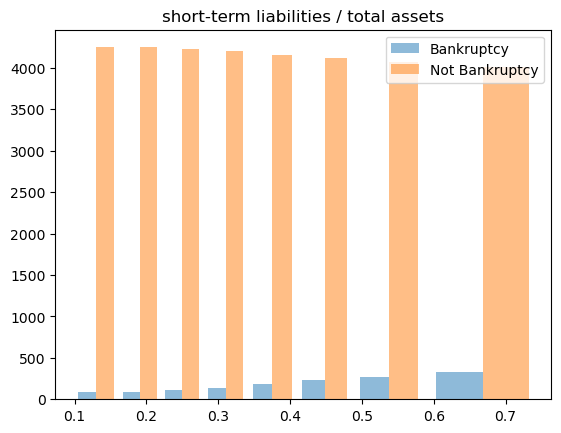

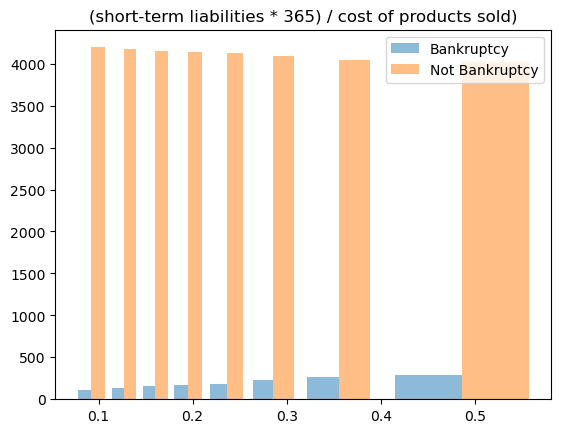

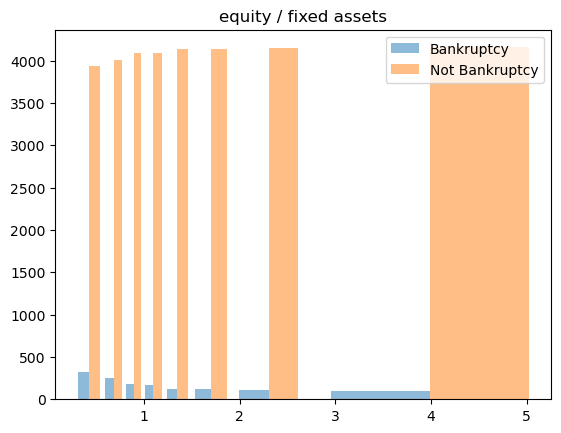

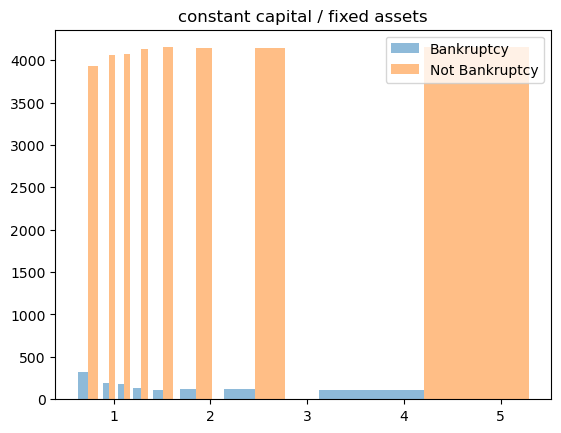

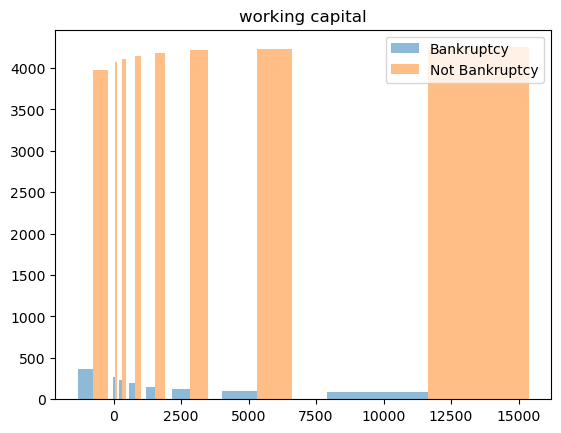

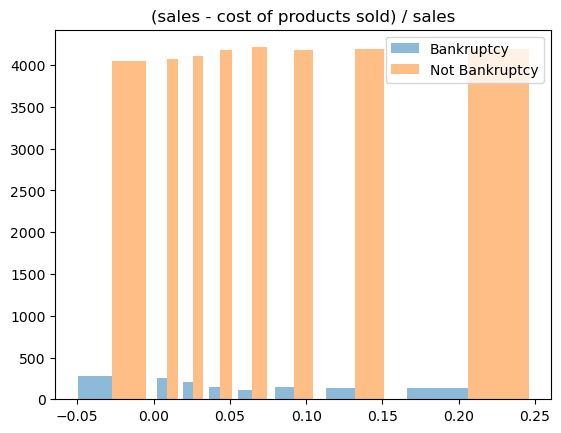

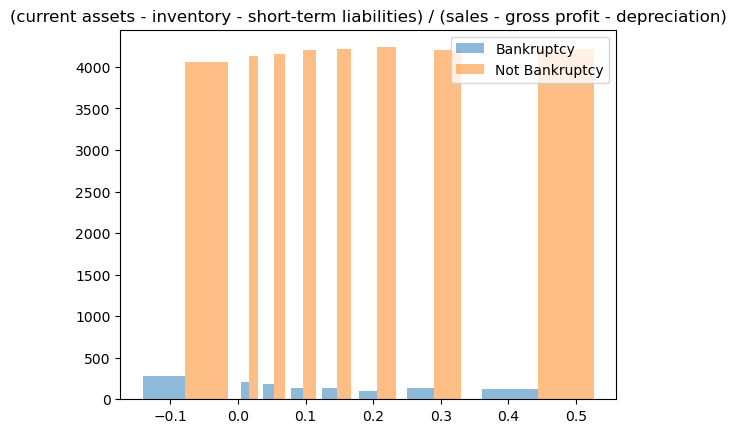

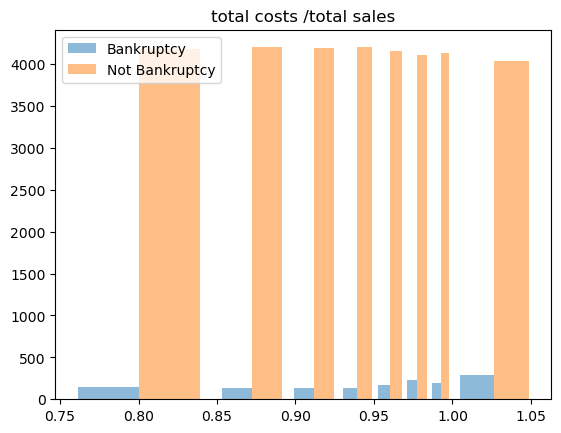

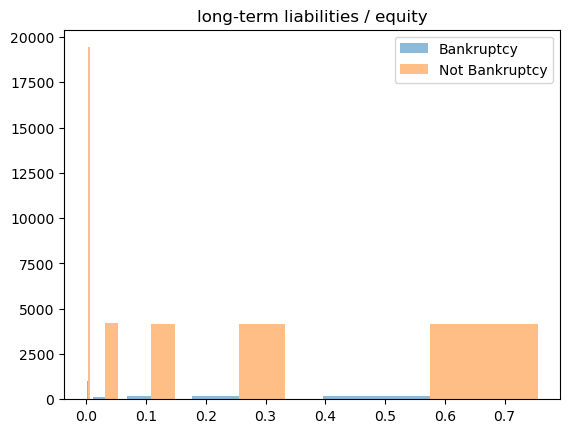

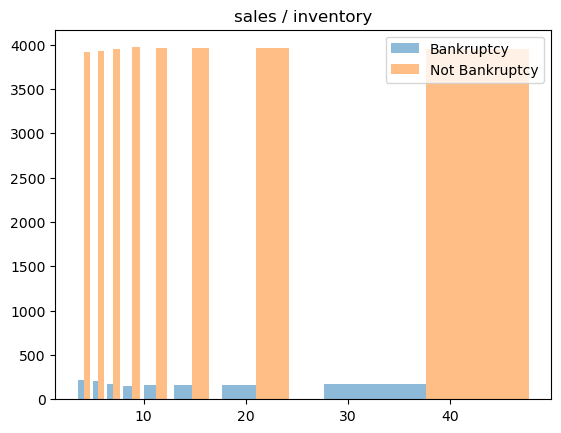

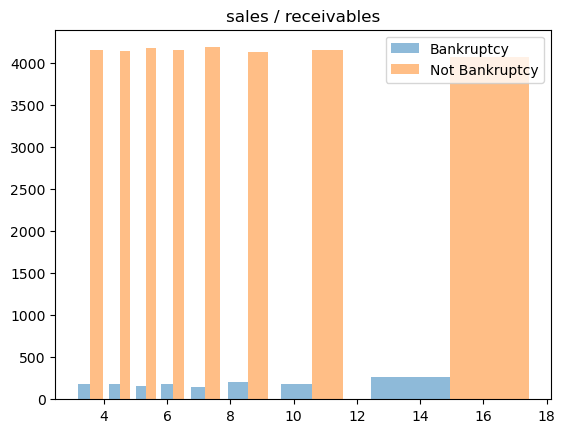

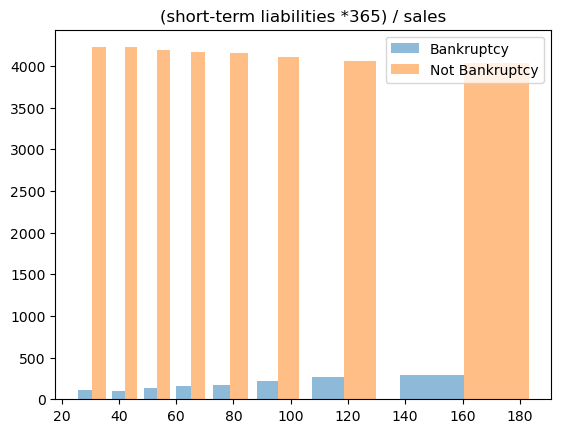

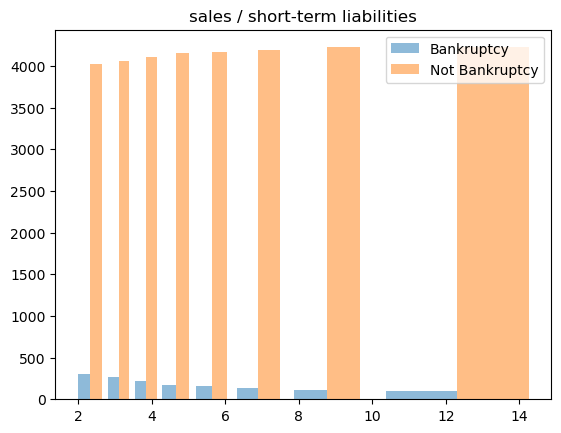

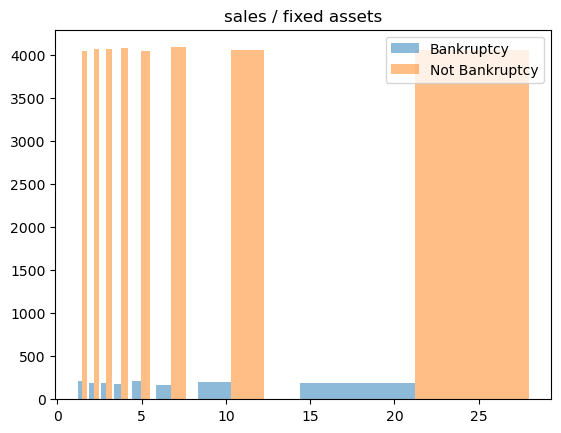

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


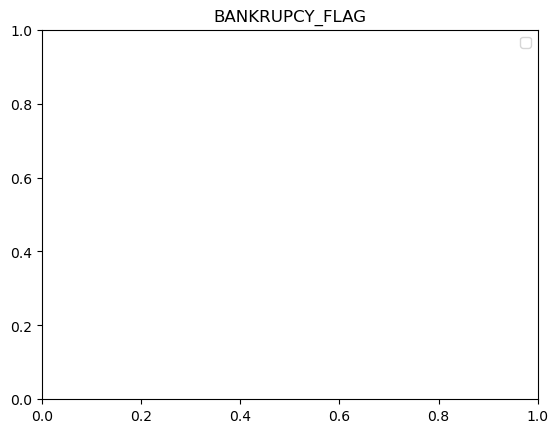

In [54]:
for i in df.columns:
    if i == "BANKRUPCY_FLAG":
        pass
    else:
    
        deciles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
        decile_values = df[i].quantile(deciles)
    
        plt.hist([df[i][df['BANKRUPCY_FLAG']==1],
                  df[i][df['BANKRUPCY_FLAG']==0]],
                 bins=decile_values, range=(-1, 1), alpha=0.5, label=['Bankruptcy', 'Not Bankruptcy'])
        
    plt.title(i)
    plt.legend()
    plt.show()
    
# First Instance of Visual Review - Different Ratios clearly have 
# Can we classify the Type of Ratio.


# Things that we expect to impact. 
# Is company Profitable
# Are Operations Profitable
# Does Company have High Debt
# Are Sales Increasing

df['PROFITABLE'] = np.where(df['net profit / total assets']>0,1,0)
df['LIQUID'] = np.where(df['current assets / short-term liabilities']>1,1,0)
df['SALES_INCREASING'] = np.where(df['sales (n) / sales (n-1)'].fillna(0)>0,1,0)
df['PROFITABLE_OPERATIONS'] = np.where(df['EBITDA (profit on operating activities - depreciation) / sales']>0,1,0)
df['EQUITY_GT_DEBT'] = np.where(df['equity / total assets']>.5,1,0)

# df['gross profit / sales']
# df['(equity - share capital) / total assets']
# df['profit on sales / sales']
# df['working capital / total assets']
# df['total costs /total sales']

#df['CASH FLOW POSITIVE'] = 

### QUESTION: Do we need to Normalize? If so how. Can it help us during review?

In [43]:
# Standardize on Max Calue such that everything is on scale 0 - 1. Due to negative numbers, slightly problematic

df1 = df.copy()

for i in df.columns:
    df1[i] = df1[i]/max(abs(df[i].max()),abs(df[i].min()))
    
# Round for Simple Value Counting
    
df2 = df.copy()

for i in df2.columns:
    df2[i] = df2[i].apply(lambda x:round(x,1))
    
    
def create_bracket(df,column_name,new_column_name):
    condition = [df[column_name]<-1,
                 df[column_name]<0,
                 df[column_name]<1,
                 df[column_name]>1]
    
    values = ['Less than -100%',
              'Between 0% - (-100%)',
              'Between 0% - 100%',
              'Above 100%']
    
    df[new_column_name] = np.select(condition,values,0)
    
create_bracket(df,'')


## Review Correlations with Data.

<Axes: title={'center': 'Correlation'}>

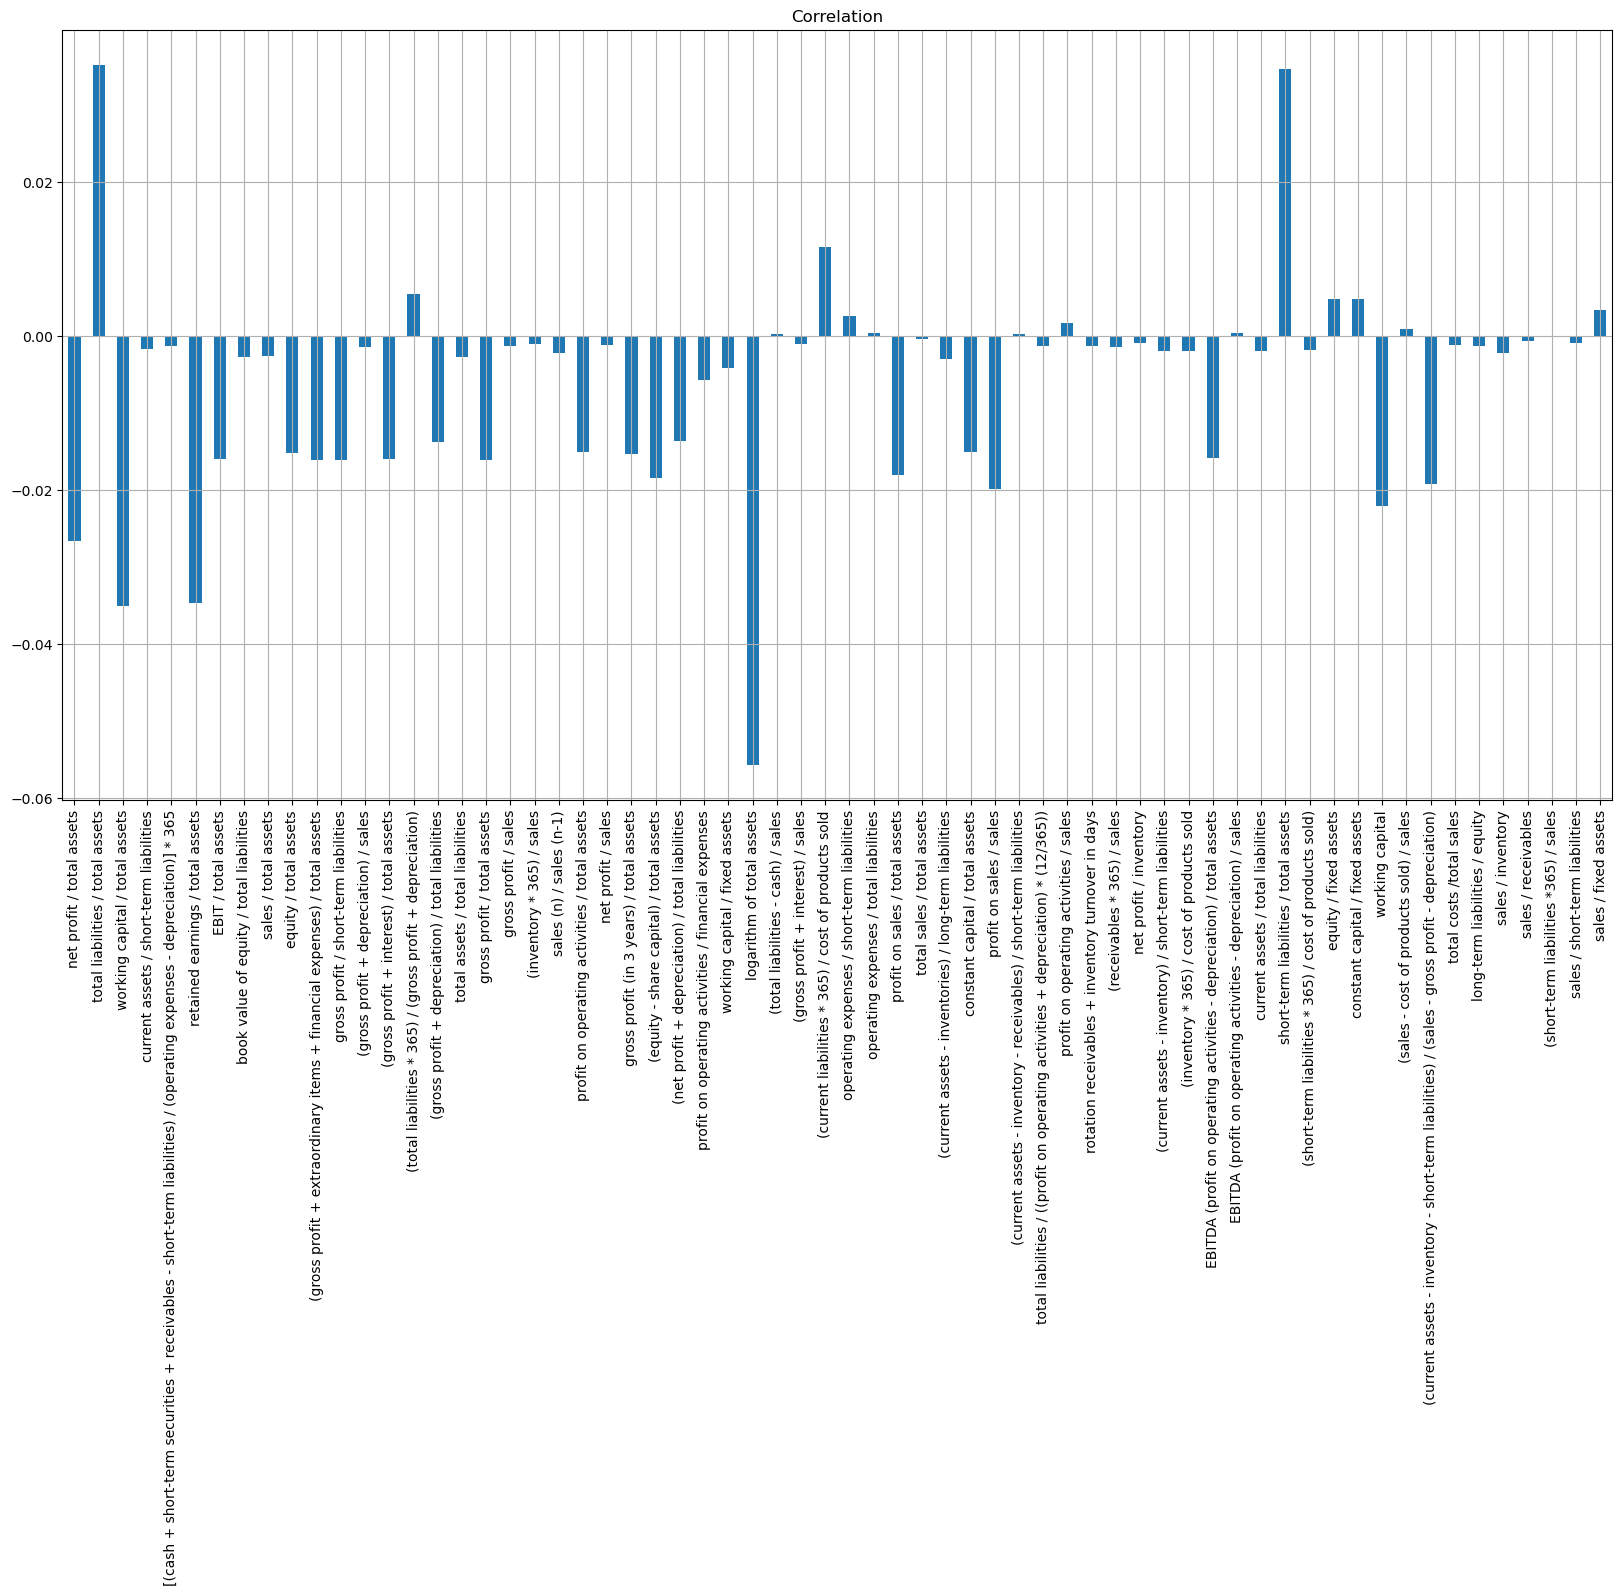

In [110]:
df.drop('BANKRUPCY_FLAG',axis=1).corrwith(df.BANKRUPCY_FLAG).plot.bar(figsize=(20,10),title='Correlation',rot=90,grid=True)

<Axes: >

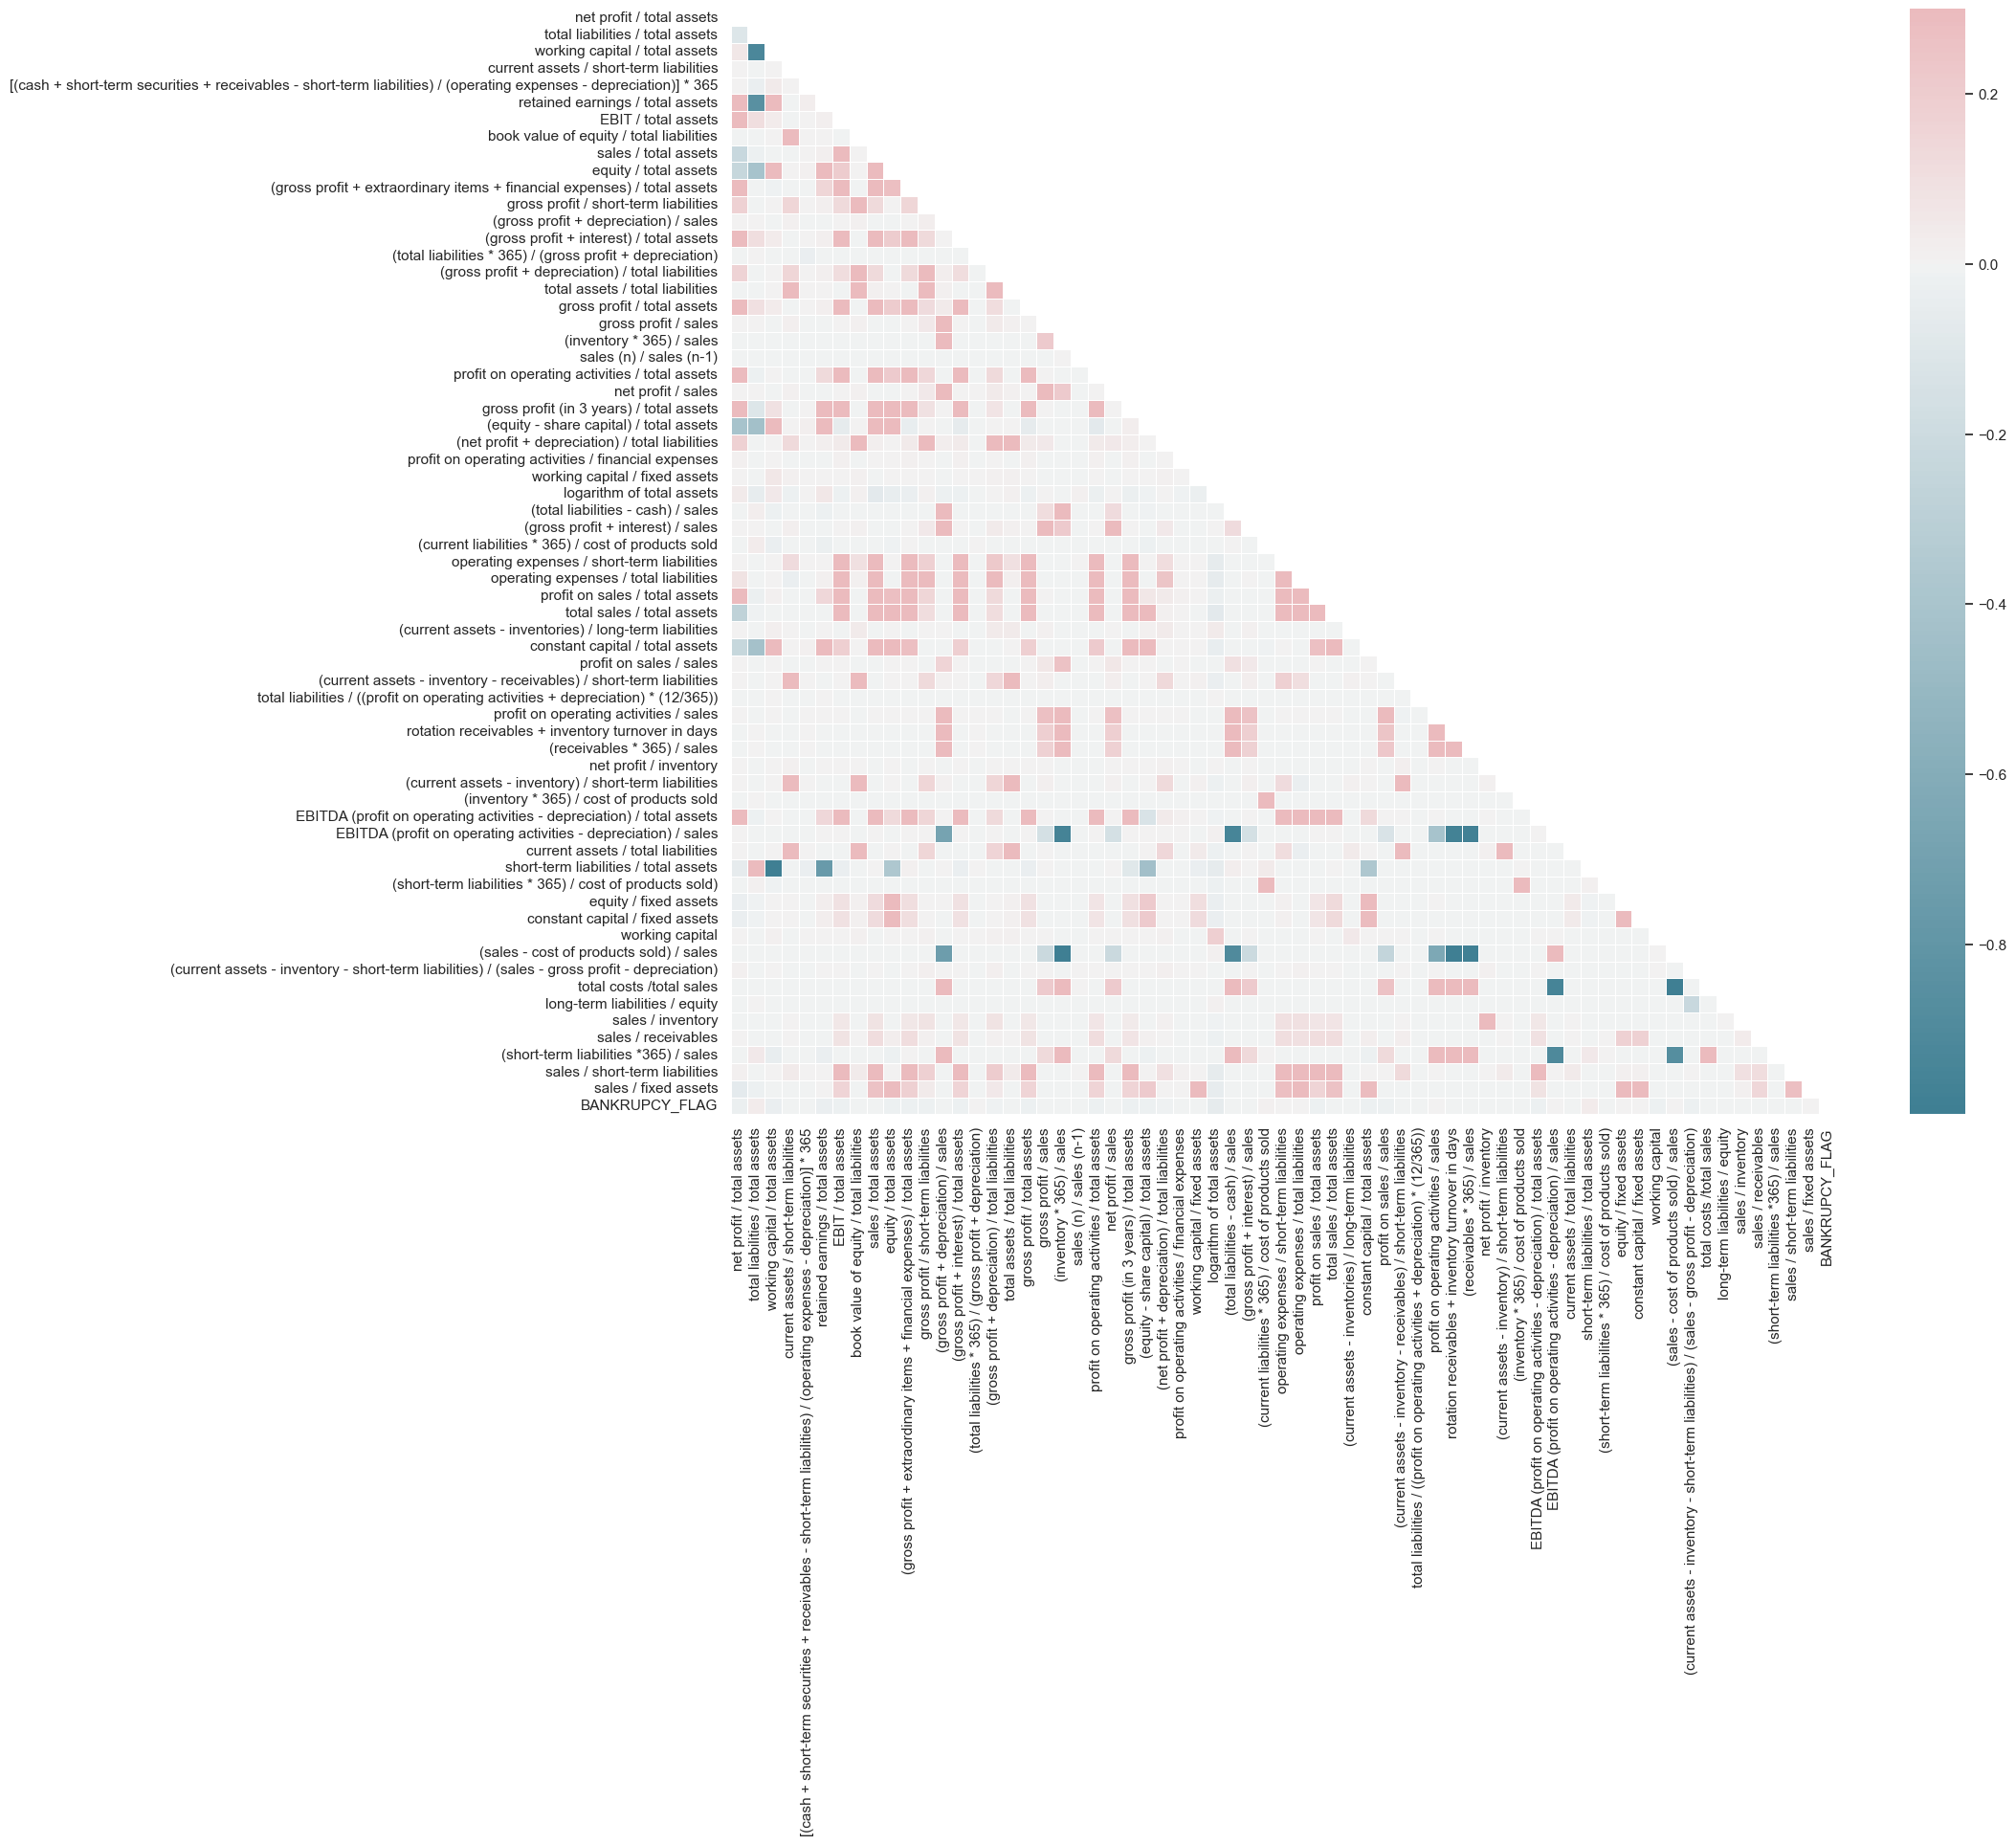

In [114]:
import seaborn as sns

sns.set(style='white')

corr = df.corr()

mask= np.zeros_like(corr,dtype=bool)
mask[np.triu_indices_from(mask)]=True

f,ax = plt.subplots(figsize=(20,15))

cmap = sns.diverging_palette(220,10,as_cmap=True)

sns.heatmap(corr,mask=mask,cmap=cmap,vmax=.3,center=0,
           square=True,linewidths=.5)

In [ ]:
###############
Should we Split before Reviewing? - Likely Answer is yes.

### Split DataFrame into Train, Test, and Validation Data Sets

In [4]:
X = df.drop('BANKRUPCY_FLAG',axis=1).copy()
y = df['BANKRUPCY_FLAG']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)
